## Import Librarys

In [1]:
from load_data import * 
from model import * 
from testing_utils import * 
from train_utils import *

## Create the dataloaders

In [4]:
loaders = create_pets_loaders(
    root="./data",
    img_size=(256,256),
    batch_size=12,
    num_workers=0,
    binary=True,
    augment=True,
    val_split=0.15)

for imgs, masks in loaders["train"]:
    print(imgs.shape, masks.shape)
    break


100%|██████████| 792M/792M [00:09<00:00, 87.0MB/s]
100%|██████████| 19.2M/19.2M [00:00<00:00, 90.1MB/s]


torch.Size([12, 3, 256, 256]) torch.Size([12, 1, 256, 256])


**We are using binary masks for the y lables**

## Lets plot the data set 

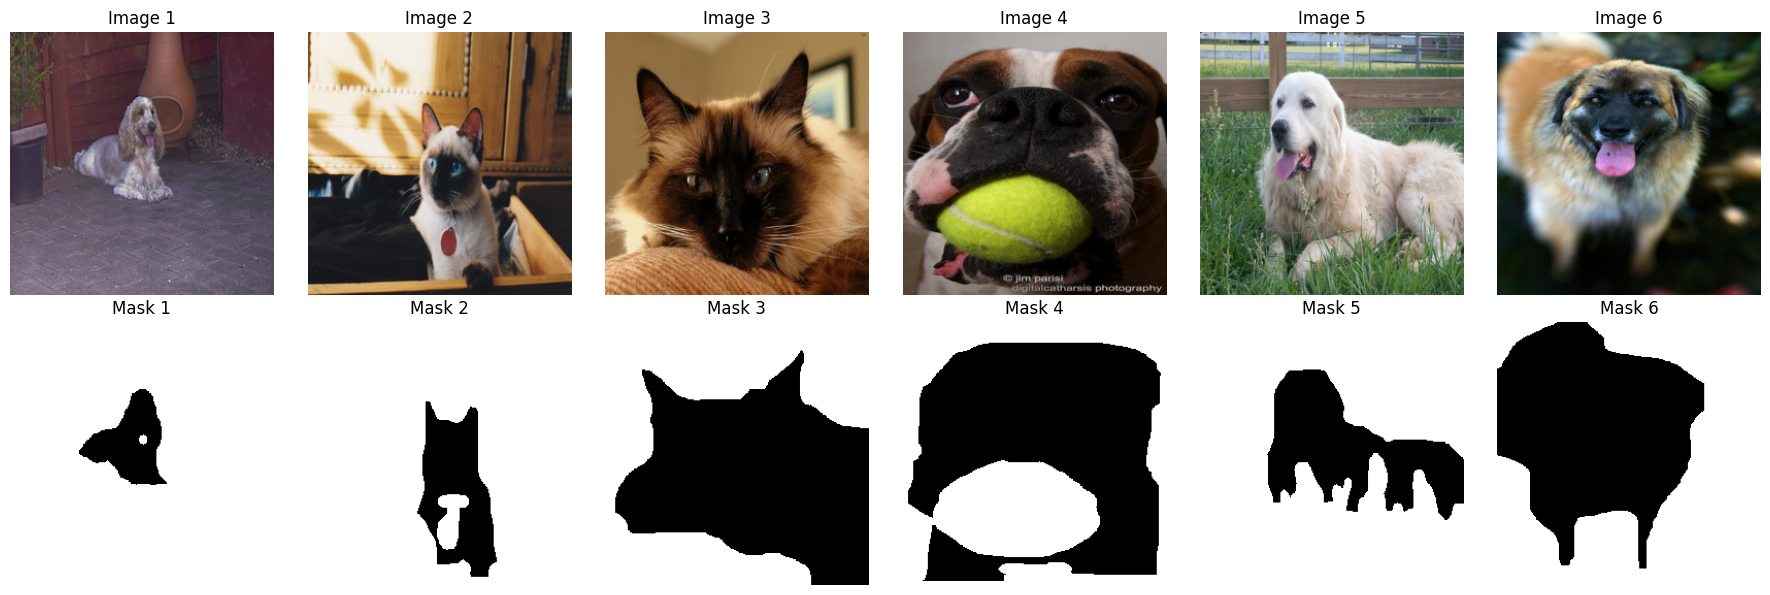

In [36]:
imgs, masks = next(iter(loaders["train"]))
show_images_and_masks(imgs, masks, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

## Create the model

In [8]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, num_classes=1).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()


## Train the model on the data set

In [9]:
epochs = 10

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_metrics = train_epoch_seg(loaders['train'], model, opt, criterion, num_classes=1, device=device, amp=True)
    val_metrics = evaluate_seg(loaders['val'], model, criterion, num_classes=1, device=device)


/tmp/ipython-input-3622621910.py:59: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp) # Crea el GradScaler (activo solo si use_amp=True)



Epoch 1/10


Train:   0%|          | 0/261 [00:00<?, ?it/s]/tmp/ipython-input-3622621910.py:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp): # Forward en precisión mixta si aplica


Train - loss: 0.5995 | pix_acc: 69.65% | Dice: 0.806


Val:   0%|          | 0/46 [00:00<?, ?it/s]/tmp/ipython-input-3622621910.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Val   - loss: 0.5590 | pix_acc: 70.74% | Dice: 0.819

Epoch 2/10


Train - loss: 0.4897 | pix_acc: 74.94% | Dice: 0.817


Val   - loss: 0.4389 | pix_acc: 78.97% | Dice: 0.842

Epoch 3/10


Train - loss: 0.4447 | pix_acc: 78.73% | Dice: 0.842


Val   - loss: 0.4173 | pix_acc: 80.52% | Dice: 0.859

Epoch 4/10


Train - loss: 0.4297 | pix_acc: 79.71% | Dice: 0.850


Val   - loss: 0.4090 | pix_acc: 80.87% | Dice: 0.862

Epoch 5/10


Train - loss: 0.4226 | pix_acc: 80.09% | Dice: 0.852


Val   - loss: 0.4042 | pix_acc: 81.32% | Dice: 0.863

Epoch 6/10


Train - loss: 0.4120 | pix_acc: 80.79% | Dice: 0.857


Val   - loss: 0.3985 | pix_acc: 81.59% | Dice: 0.860

Epoch 7/10


Train - loss: 0.3945 | pix_acc: 82.02% | Dice: 0.865


Val   - loss: 0.3708 | pix_acc: 83.11% | Dice: 0.871

Epoch 8/10


Train - loss: 0.3663 | pix_acc: 83.58% | Dice: 0.874


Val   - loss: 0.3409 | pix_acc: 84.98% | Dice: 0.887

Epoch 9/10


Train - loss: 0.3421 | pix_acc: 84.86% | Dice: 0.882


Val   - loss: 0.3534 | pix_acc: 84.18% | Dice: 0.886

Epoch 10/10


Train - loss: 0.3286 | pix_acc: 85.48% | Dice: 0.887


Val   - loss: 0.3408 | pix_acc: 84.98% | Dice: 0.891


# Evaluation of the model 

***

### Segmentation Performance Evaluation

We evaluated the model's segmentation performance using per-pixel probability maps and an error overlay visualization. The left panel shows the input image, the middle panel overlays the predicted probability map (after sigmoid activation) onto the image, and the right panel highlights the classification outcomes:

- **Green (TP)** – Correctly segmented regions.
- **Red (FP)** – Background pixels incorrectly predicted as foreground.
- **Blue (FN)** – Foreground pixels missed by the model.

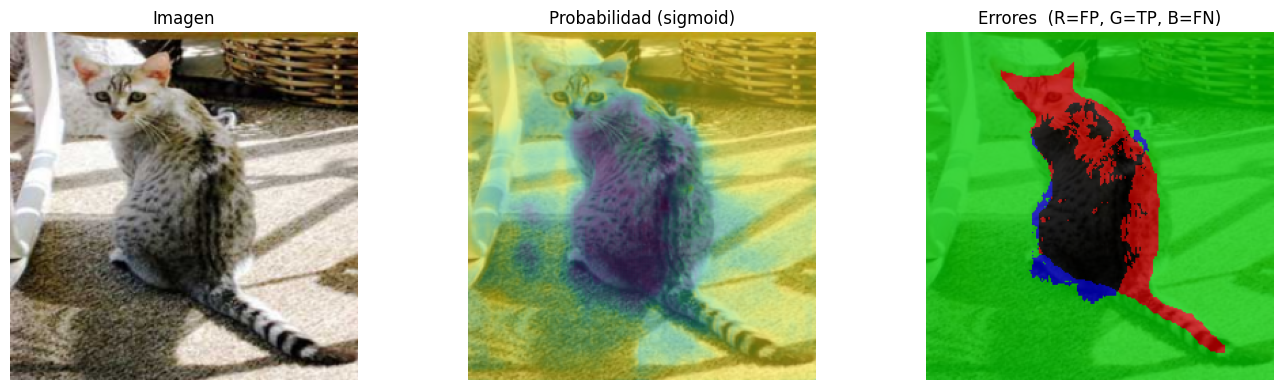

In [34]:

model.eval()
with torch.no_grad():
    xb, yb = next(iter(loaders['val']))
    xb1, yb1 = xb[:1].to(device), yb[:1].to(device)
    out = model(xb1)

imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

viz_overlay_errors(xb1, out, yb1, thr=0.5, mean=imagenet_mean, std=imagenet_std)


The results show that the model successfully captures the main object shape and boundaries, with most of the cat's body correctly segmented (green). However, there are some false positives along the background edges and a few false negatives around fine details, such as the tail tip and body contour. These errors suggest the model is generally accurate but could benefit from improved handling of thin structures and background-foreground transitions.

***

### Precision–Recall and ROC Curve Analysis

We also evaluated the model’s pixel-wise classification performance using the `plot_pr_roc_from_logits` function.  
This function takes the raw model logits and ground truth masks, computes per-pixel probabilities via the sigmoid function,  
and then calculates and plots the following metrics:

- **Precision–Recall (PR) Curve:** Shows the trade-off between precision and recall across thresholds.  
- **Average Precision (AP):** 0.969 in this evaluation, indicating consistently high precision even at high recall.  
- **Receiver Operating Characteristic (ROC) Curve:** Plots the true positive rate (TPR) vs. false positive rate (FPR).  
- **Area Under the ROC Curve (AUC):** 0.928, reflecting strong separability between positive (foreground) and negative (background) pixels.


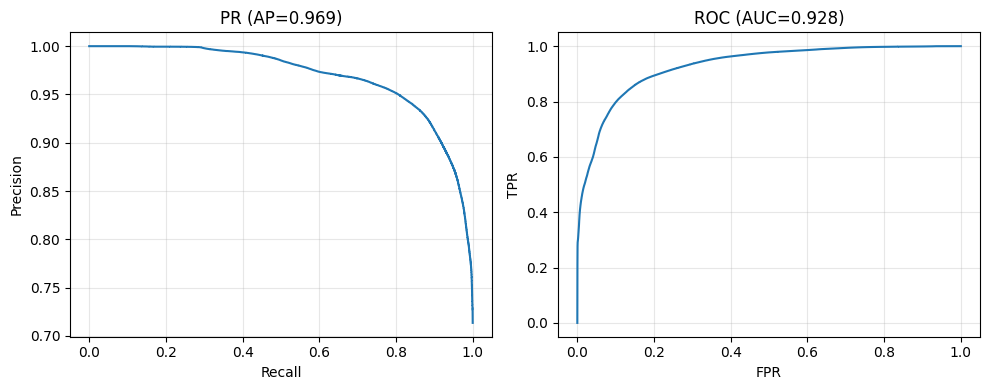

In [11]:

model.eval()
with torch.no_grad():
    xb, yb = next(iter(loaders['val']))
    xb, yb = xb.to(device), yb.to(device)
    logits = model(xb)
plot_pr_roc_from_logits(logits, yb)


These metrics provide a threshold-independent view of model performance and complement segmentation-specific scores (such as Dice or IoU),  
allowing for a more complete understanding of the model’s discriminative ability.

***

### Image-level Overlap Metrics (Dice & IoU)

We computed **per-image Dice and IoU** from raw model logits using two utility functions:

- `dice_per_image_from_logits(logits, yb, thr=0.5)`: applies a sigmoid to logits, binarizes predictions at threshold `thr`, and returns a Dice score **per image** in the batch.
- `iou_per_image_from_logits(logits, yb, thr=0.5)`: same pipeline, returning IoU **per image**.
- Both functions accept masks as `[B,1,H,W]` or `[B,H,W]` and use a small `eps` for numerical stability.

The helper `plot_hist_metrics(dices, ious)` visualizes the distribution of scores across the dataset.


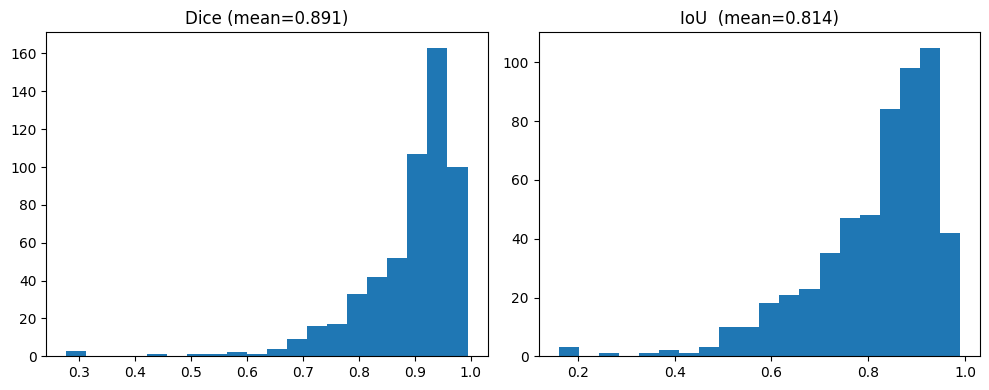

In [12]:

model.eval()
all_dice, all_iou = [], []
with torch.no_grad():
    for xb, yb in loaders['val']:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        all_dice.extend(dice_per_image_from_logits(logits, yb))
        all_iou.extend(iou_per_image_from_logits(logits, yb))
plot_hist_metrics(np.array(all_dice), np.array(all_iou))


**Current results (threshold = 0.5):**
- **Mean Dice:** 0.891  
- **Mean IoU:** 0.814  
- Histograms are **right-skewed**, indicating most images achieve high overlap, with a small tail of harder cases.

**Interpretation & notes:**
- Dice ≈ 0.89 suggests strong region overlap; IoU ≈ 0.81 is consistent with that level of performance.
- Low-scoring outliers likely correspond to thin structures/boundaries or atypical backgrounds; inspecting these helps guide error analysis.
- Since these metrics depend on the binarization threshold, we keep `thr=0.5` fixed for reporting; threshold tuning (e.g., maximizing Dice on a val set) can further refine performance.

*** 

### Pixel-level Calibration Analysis

We assess how well predicted probabilities reflect true frequencies using the `calibration_curve_pixels` function.  
This function converts logits to probabilities with a sigmoid, bins pixels into `n_bins` equal-width bins over `[0,1]`, and, for each bin, plots:
- **Mean predicted confidence** (x-axis)
- **Empirical positive rate** (y-axis)

The dashed diagonal is perfect calibration (`confidence = accuracy`). Points **below** the diagonal indicate **overconfidence** (predicted probabilities are too high), and points **above** indicate **underconfidence**.

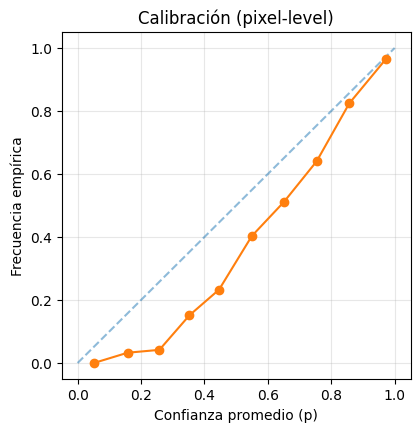

In [13]:

with torch.no_grad():
    xb, yb = next(iter(loaders['val']))
    xb, yb = xb.to(device), yb.to(device)
    logits = model(xb)
calibration_curve_pixels(logits, yb)

**Observed behavior (this run):**
- The curve is **below the diagonal** for low–mid confidences (~0.2–0.6) → the model is **overconfident** in that range.
- Around ~0.8, it slightly crosses **above** the diagonal (mild **underconfidence**).
- Near 1.0, it approaches the diagonal (close to perfectly calibrated at high confidence).

**Usage note:** This is a pixel-wise analysis for binary segmentation; it complements overlap metrics (Dice/IoU) by checking the **probabilistic reliability** of the model. If needed, temperature scaling or Platt/Isotonic calibration can be applied on a validation set to reduce miscalibration (e.g., minimizing ECE) before final reporting.

*** 

### Convolutional Feature Map Visualization

We inspected the internal representations learned by the model by visualizing the output of a selected convolutional layer using a forward hook.  
The visualization displays **12 feature maps** from a `Conv2d` layer, each highlighting different spatial patterns and textures detected by the network.

**Purpose of the function:**  
The feature map visualization function registers a forward hook on a chosen layer, captures its activation output during a forward pass, and displays a subset of channels (feature maps) after normalizing them to the [0,1] range for display.

Encontré estas capas: ['conv1.net.0', 'conv2.net.0']


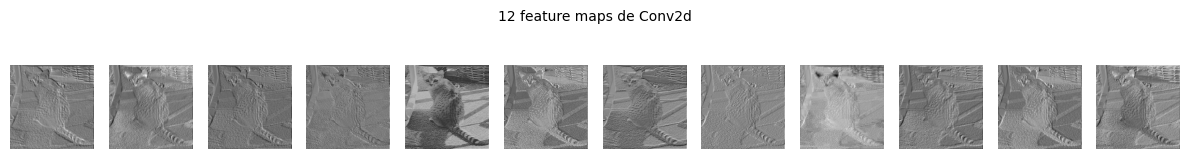

In [27]:

clear_all_hooks(model)
xb, _ = next(iter(loaders['val']))
xb1 = xb[:1].to(device)
# ejemplo: una capa concreta de tu modelo
layer = pick_layer(model.enc[0], nn.Conv2d, idx=0)
visualize_feature_maps(model, layer=layer, xb=xb1, num_maps=12)


**Insights from this example:**
- Several maps emphasize **edges and contours** of the cat and background structures.
- Some channels capture **fine textures** (e.g., fur patterns, surface details), while others respond to **larger structural regions**.
- The diversity in activation patterns suggests the layer is learning a mix of **low- to mid-level visual features** that will be further processed in deeper layers.

This type of analysis is useful for understanding **what the model focuses on** at different depths, diagnosing potential biases, and guiding architectural or training adjustments.

*** 

### Bottleneck Representation Analysis (UMAP/t-SNE)

We probe the model’s **latent space** by extracting activations at the bottleneck layer and projecting them to 2D with UMAP/t-SNE.

**What the functions do**
- `collect_bottleneck(model, loader, hook_layer)`: registers a forward hook on the selected bottleneck module, collects its activations over the dataset, flattens them to `[N, D]`, and (optionally) returns labels `Y` if provided by the loader.
- `plot_embedding_2d(X, Y=None, method="umap", n=5000)`: reduces the first `n` vectors in `X` to 2D (UMAP if available, else t-SNE) and plots them; if `Y` is given, points are color-coded by class.

**What we are evaluating**
- **Geometry of the latent space**: whether samples form coherent clusters or exhibit clear margins, which reflects the model’s ability to learn **class-separable** or **structure-aware** features before decoding.


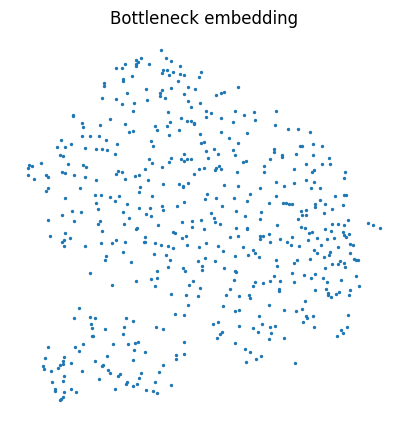

In [28]:

clear_all_hooks(model)
hook_layer = model.bottleneck if hasattr(model, "bottleneck") else list(model.modules())[-2]
X, Y = collect_bottleneck(model, loaders['val'], device, hook_layer)
plot_embedding_2d(X, Y=None, method="umap")

**Observed behavior (this run)**
- The embedding shows a **diffuse cloud** with mild local groupings but **no sharply separated clusters**. This suggests the bottleneck captures useful continuous variations, yet global separability is limited in this projection.

**How to use this insight**
- If labels exist, re-plot with `Y` to assess **class separation** (e.g., boundary vs. background).
- Quantify structure with **k-NN purity**, **Silhouette score**, or **Linear Probe** accuracy on `X`.
- If separation is weak, consider stronger supervision/regularization at the bottleneck (e.g., contrastive loss, auxiliary heads) or increasing capacity/context (dilations, attention).

*** 

### Boundary Quality Metrics (Boundary-F1 and Hausdorff Distance)

We evaluate **edge fidelity** of the predicted masks using two boundary-focused metrics:

- **Boundary-F1 (with pixel tolerance):**  
  We compute binary boundary maps for prediction and ground truth, apply a symmetric dilation with tolerance `±2 px`, and measure precision/recall of boundary hits. The F1 summarizes alignment of predicted and true edges while being robust to small pixel shifts.

- **Symmetric Hausdorff Distance (on boundaries):**  
  We extract boundary points and compute the maximum of the two directed Hausdorff distances. This captures the **worst-case** boundary deviation (in pixels) between prediction and ground truth.

In [29]:

with torch.no_grad():
    xb, yb = next(iter(loaders['val']))
    xb1, yb1 = xb[:1].to(device), yb[:1].to(device)
    logits = model(xb1)
prob = torch.sigmoid(logits)[0,0].cpu().numpy()
pred = (prob>0.5).astype(np.uint8)

gt = yb1[0]
if gt.dim()==3: gt = gt[0]
gt = gt.cpu().numpy().astype(np.uint8)

bf1, bprec, brec = boundary_f1(pred, gt, tol=2)
hd = hausdorff_distance(pred, gt)
print("Boundary-F1:", bf1, "Hausdorff:", hd)

Boundary-F1: 0.6027826915546971 Hausdorff: 49.678969393496885


**Current results**
- **Boundary-F1 (tol=2 px):** **0.603**  
  → Moderate edge alignment: many contours are captured, but there are noticeable misses or small offsets—especially on thin structures and high-curvature regions.
- **Hausdorff distance:** **49.68 px**  
  → There exist localized regions with large boundary gaps (outliers), indicating occasional over/under-segmentation or broken contours.

**Interpretation & next steps**
- The mask overlaps (Dice/IoU) are strong, but boundary metrics reveal **edge brittleness**.  
- To improve: increase boundary awareness via loss terms (e.g., Dice+Boundary loss, Laplacian/level-set losses), add high-resolution skip connections or dilated convolutions, refine post-processing (CRF/graph cut/thinning), and augment data with **edge-focused** transformations (small shifts, elastic, thin-structure emphasis).

*** 

### Occlusion Sensitivity Analysis (ΔDice)

We assessed the **spatial importance** of different image regions for the segmentation model using an occlusion sensitivity test.  
The method systematically replaces small patches of the input with a neutral value and measures the resulting **drop in Dice score (ΔDice)** compared to the unoccluded prediction.

**What the function does:**
1. Runs the model on the original image to obtain a baseline Dice score against the ground truth mask.
2. Iteratively occludes patches (`patch` size, `stride` configurable) by replacing them with a neutral fill value.
3. Recomputes the prediction and Dice score after each occlusion.
4. Stores the Dice drop in a **heatmap**, where higher values indicate greater importance of that region for accurate segmentation.

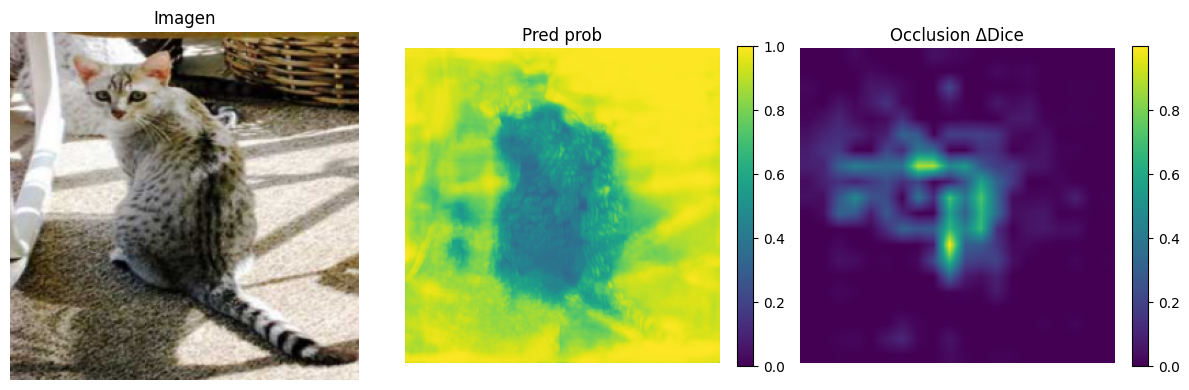

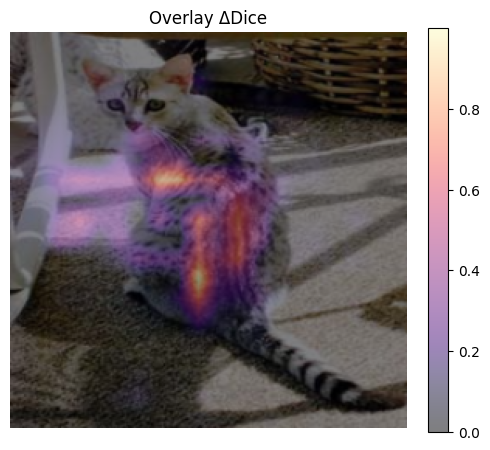

In [32]:

with torch.no_grad():
    xb, yb = next(iter(loaders['val']))
heat = occlusion_sensitivity(model, xb[:1], yb[:1], patch=24, stride=12, device=device)

**Observed behavior (this run):**
- The heatmap highlights the **torso and upper body** of the cat as the most influential regions for the model’s segmentation decision.
- Background regions show near-zero ΔDice, confirming they have little effect on the output.
- The overlay visualization confirms that the **highest-sensitivity zones** align with the object’s structural core, where precise boundary placement is critical.

**Interpretation:**
- The model’s reliance is concentrated on central object features, suggesting it uses **texture and shape cues** from the main body rather than relying heavily on peripheral or background context.
- Occlusion sensitivity is complementary to saliency or Grad-CAM maps, providing a **quantitative, metric-driven** measure of feature importance tied directly to segmentation accuracy.

## Pablo Reyes 